In [105]:
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import numpy as np 
import seaborn as sns

This script takes a GOES flare list that has been created using `final_flare_pos.py` and an AR list
created using `get_ar_data.py` and merges them to create a flare list that then includes AR data associated with each flare.
You can also merge it the other way if you like to create an AR database (for each day) with associated flares. 

It outputs a csv file of the merged flare and AR property list.


In [42]:
## read in flarelist
flare_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/swpc_flarelist_19960731_20181231.csv")
# create a column "matchtime" which will be used to merge with the AR data
flare_list["matchtime"] = pd.to_datetime(flare_list["start_time"], format="%Y-%m-%d %H:%M:%S").dt.strftime("%Y-%m-%d 00:30")

# tidying up some other columns (i.e. make AR num a string, and sort out dates of start, peak and end of flare)
flare_list["noaa_ar"] = flare_list["noaa_ar"].astype(str)

def get_goes_class(x):
    try:
        if x[0]=="C":
            return float(x[1:])*1e-6
        elif x[0] == "M":
            return float(x[1:])*(1e-5)
        elif x[0] == "X":
            return float(x[1:])*(1e-4)
        else:
            return
    except:
        return np.nan
    
flare_list["goes_class_val"] = flare_list["goes_class"].map(get_goes_class)

In [43]:
flare_list.head(2)

,date,event_no,start_time,max_time,end_time,goes_sat,goes_channel,goes_class_ind,goes_class,integrated_flux,noaa_ar,ts,matchtime,goes_class_val
0,19960806,4370,1996-08-06 19:10:00,2201,1996-08-06 22:43:00,GO9,1-8A,C,C1.5,8.23E-0,0,199608061910,1996-08-06 00:30,0.000002
1,19960807,4420,1996-08-07 23:16:00,2320,1996-08-07 23:24:00,GO9,1-8A,C,C1.0,2.90E-0,0,199608072316,1996-08-07 00:30,0.000001


In [44]:
ar_data.head(2)

,ar_noaanum,LOCATION,Carrington_long,AREA,Z,Longitude_extent,No_sunspots,MAGTYPE,date,matchtime,noaa_ar
0,7935,N11W06,205,10,BXO,8,4.0,BETA,1996-01-02 00:30,1996-01-02 00:30,7935
1,7937,S09E49,150,0,AXX,1,1.0,ALPHA,1996-01-02 00:30,1996-01-02 00:30,7937


In [45]:
# read in active region list
ar_data = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/AR_analysis/SRS_data_new_19960101_20181231.csv")

# # similarly create a "matchtime" columns
ar_data["matchtime"] = pd.to_datetime(ar_data["date"]).dt.strftime("%Y-%m-%d 00:30")
# # rename AR column so that it can be merged with GOES flare list
ar_data["noaa_ar"] = ar_data["ar_noaanum"].astype(str)
ar_data.drop(columns=["NM", "NONE", "BETA"], inplace=True)
# ar_data.rename(columns={"date":"AR issue_date"}, inplace=True)



In [46]:
ar_data.head(3)

,ar_noaanum,LOCATION,Carrington_long,AREA,Z,Longitude_extent,No_sunspots,MAGTYPE,date,matchtime,noaa_ar
0,7935,N11W06,205,10,BXO,8,4.0,BETA,1996-01-02 00:30,1996-01-02 00:30,7935
1,7937,S09E49,150,0,AXX,1,1.0,ALPHA,1996-01-02 00:30,1996-01-02 00:30,7937
2,7934,S08W60,245,0,AXX,0,1.0,ALPHA,1996-01-03 00:30,1996-01-03 00:30,7934


In [47]:
flare_list2 = flare_list[~flare_list["noaa_ar"].isin(["0"])]

In [48]:
## merge the files!
merged_db = pd.merge(flare_list2, ar_data, how="left", on=["matchtime", "noaa_ar"])
merged_db["noaa_ar"] = merged_db["noaa_ar"].replace(["\n","", "     "], 0)
merged_db.drop_duplicates(subset="start_time", keep="last", inplace=True)
merged_db.reset_index(inplace=True, drop=True)

In [49]:
flare_ar_df = merged_db[~merged_db["ar_noaanum"].isnull()]

In [50]:
len(flare_ar_df)/len(merged_db)

0.9036406448107227

In [51]:
flare_ar_df.head(2)

,date_x,event_no,start_time,max_time,end_time,goes_sat,goes_channel,goes_class_ind,goes_class,integrated_flux,...,goes_class_val,ar_noaanum,LOCATION,Carrington_long,AREA,Z,Longitude_extent,No_sunspots,MAGTYPE,date_y
0,19960825,4730,1996-08-25 12:10:00,1236,1996-08-25 12:39:00,GO9,1-8A,C,C1.0,8.36E-0,...,0.000001,7986.0,S12E64,258.0,90.0,HSX,2.0,1.0,ALPHA,1996-08-25 00:30
1,19961124,6350,1996-11-24 17:31:00,1747,1996-11-24 17:59:00,GO9,1-8A,C,C2.8,4.03E-0,...,0.000003,7999.0,S04E33,169.0,170.0,DAO,8.0,21.0,BETA,1996-11-24 00:30


In [52]:
flare_ar_df["MAGTYPE"].unique()

array(['ALPHA', 'BETA', 'BETA-GAMMA', 'BETA-GAMMA-DELTA', 'GAMMA-DELTA',
       'BETA-DELTA', 'GAMMA'], dtype=object)

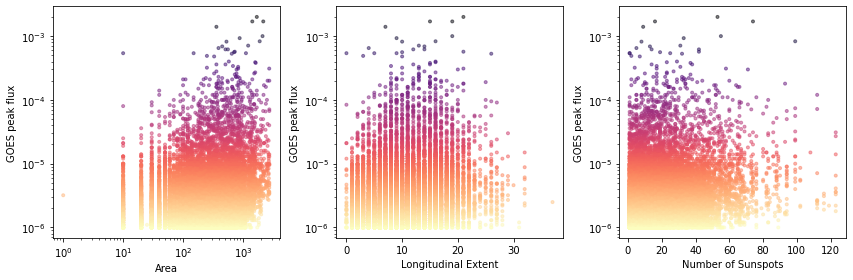

In [56]:
cmap = "magma_r"
fig, ax = plt.subplots(1, 3, figsize=(12, 4))


ax[0].scatter(flare_ar_df["AREA"], flare_ar_df["goes_class_val"], marker='.', c=  flare_ar_df["goes_class_val"], 
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_ylabel("GOES peak flux")
ax[0].set_xlabel("Area")

ax[1].scatter(flare_ar_df["Longitude_extent"], flare_ar_df["goes_class_val"], marker='.', c=flare_ar_df["goes_class_val"], 
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[1].set_yscale("log")
ax[1].set_ylabel("GOES peak flux")
ax[1].set_xlabel("Longitudinal Extent")

ax[2].scatter(flare_ar_df["No_sunspots"], flare_ar_df["goes_class_val"], marker='.',  c=flare_ar_df["goes_class_val"],
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[2].set_yscale("log")
ax[2].set_ylabel("GOES peak flux")
ax[2].set_xlabel("Number of Sunspots")

plt.tight_layout()

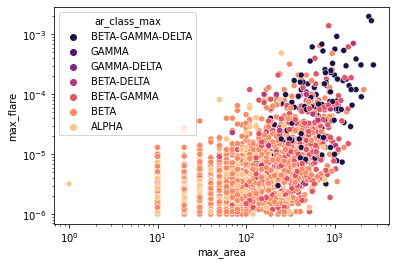

In [108]:
unique_ar = flare_ar_df["noaa_ar"].unique()
events = []
for ar in unique_ar:
    unique_df = flare_ar_df[flare_ar_df.noaa_ar.isin([ar])]
    event = {}
    event["ar_num"] = ar
    event["max_flare"] = np.max(unique_df["goes_class_val"])
    event["max_area"] = np.max(unique_df["AREA"])
    event["ar_class_max"] = unique_df.iloc[np.argmax(unique_df["goes_class_val"])]["MAGTYPE"]
    events.append(event)


events = pd.DataFrame(events)

events = events[events.max_area>0]

order = ['ALPHA', 'BETA', 'BETA-GAMMA', 'BETA-DELTA', 'GAMMA-DELTA',  'GAMMA', 'BETA-GAMMA-DELTA',]
sns.scatterplot(data=events, x="max_area", y="max_flare", hue="ar_class_max", palette="magma", hue_order=order[::-1])
plt.xscale("log")
plt.yscale("log")

In [122]:
testy = flare_ar_df.groupby(["MAGTYPE", "goes_class_ind"])["goes_class"].count().unstack()
testy2 = testy/flare_ar_df["goes_class_ind"].value_counts()

<AxesSubplot:xlabel='MAGTYPE'>

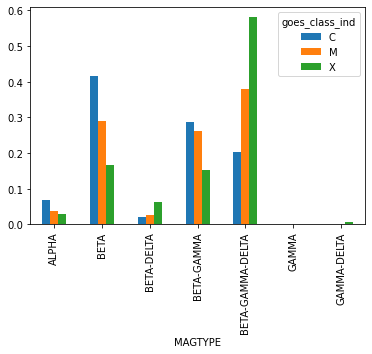

In [123]:
testy2.plot.bar()

<AxesSubplot:xlabel='MAGTYPE'>

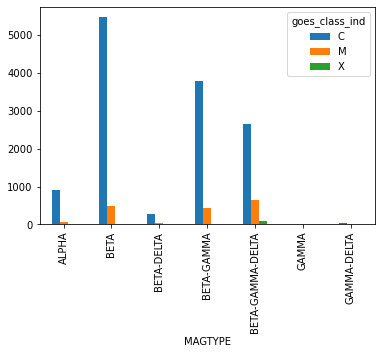

In [121]:
flare_ar_df.groupby(["MAGTYPE", "goes_class_ind"])["goes_class_ind"].count().unstack().plot.bar()

Text(0, 0.5, '% of total events (per class)')

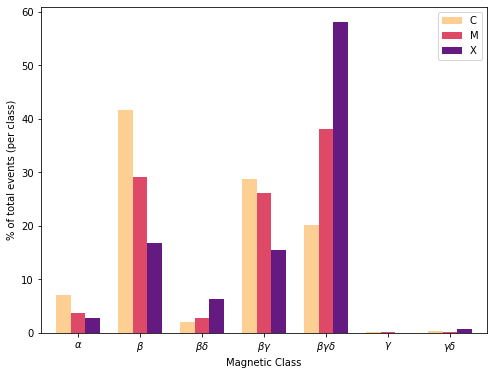

In [185]:
order = ['ALPHA', 'BETA', 'BETA-GAMMA', 'BETA-GAMMA-DELTA', 'GAMMA-DELTA', 'BETA-DELTA', 'GAMMA']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\gamma\delta$', r'$\gamma\delta$', r'$\beta\delta$',r'$\gamma$',]

label_dict = {'ALPHA': r'$\alpha$',
              'BETA': r'$\beta$',
              'BETA-DELTA': r'$\beta\delta$',
              'BETA-GAMMA': r'$\beta\gamma$',
              'BETA-GAMMA-DELTA': r'$\beta\gamma\delta$', 
              'GAMMA' : r'$\gamma$', 
              'GAMMA-DELTA': r'$\gamma\delta$',}



marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0.1,1,4))

testy2 = 100*(testy/flare_ar_df["goes_class_ind"].value_counts())
labels = [label_dict[x] for x in testy2.index]
fig, ax = plt.subplots(figsize=(8, 6))
testy2.plot.bar(color=colors, ax=ax, width=0.7)
ax.legend(["C", "M", "X"])
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel("Magnetic Class")
ax.set_ylabel("% of total events (per class)")


In [183]:
labels = [label_dict[x] for x in testy2.index]
labels

['$\\alpha$',
 '$\\beta$',
 '$\\beta\\delta$',
 '$\\beta\\gamma$',
 '$\\beta\\gamma\\delta$',
 '$\\gamma$',
 '$gamma\\delta$']

In [127]:
flare_ar_df[flare_ar_df["MAGTYPE"].isin(["GAMMA-DELTA"])].tail()

,date_x,event_no,start_time,max_time,end_time,goes_sat,goes_channel,goes_class_ind,goes_class,integrated_flux,...,goes_class_val,ar_noaanum,LOCATION,Carrington_long,AREA,Z,Longitude_extent,No_sunspots,MAGTYPE,date_y
6600,20030701,5160,2003-07-01 13:33:00,1343,2003-07-01 14:03:00,G12,1-8A,C,C2.3,3.3E-03,...,0.000002,10397.0,N11E40,34.0,850.0,FHI,18.0,30.0,GAMMA-DELTA,2003-07-01 00:30
6601,20030701,5260,2003-07-01 17:54:00,1802,2003-07-01 18:06:00,G12,1-8A,C,C1.4,7.8E-04,...,0.000001,10397.0,N11E40,34.0,850.0,FHI,18.0,30.0,GAMMA-DELTA,2003-07-01 00:30
6602,20030701,5270,2003-07-01 18:40:00,1902,2003-07-01 19:29:00,G12,1-8A,C,C1.1,2.6E-03,...,0.000001,10397.0,N11E40,34.0,850.0,FHI,18.0,30.0,GAMMA-DELTA,2003-07-01 00:30
6603,20030701,5280,2003-07-01 20:10:00,2029,2003-07-01 20:45:00,G12,1-8A,C,C1.0,1.8E-03,...,0.000001,10397.0,N11E40,34.0,850.0,FHI,18.0,30.0,GAMMA-DELTA,2003-07-01 00:30
6604,20030702,5420,2003-07-02 07:06:00,0728,2003-07-02 07:46:00,G12,1-8A,M,M3.0,4.7E-02,...,0.000030,10397.0,N12E26,34.0,770.0,EKI,15.0,28.0,GAMMA-DELTA,2003-07-02 00:30


In [129]:
flare_ar_df[flare_ar_df["MAGTYPE"].isin(["BETA-GAMMA-DELTA"])].head()

,date_x,event_no,start_time,max_time,end_time,goes_sat,goes_channel,goes_class_ind,goes_class,integrated_flux,...,goes_class_val,ar_noaanum,LOCATION,Carrington_long,AREA,Z,Longitude_extent,No_sunspots,MAGTYPE,date_y
116,19971104,3950,1997-11-04 01:13:00,0116,1997-11-04 01:20:00,GO9,1-8A,C,C3.7,1.3E-03,...,0.000004,8100.0,S20W27,353.0,660.0,FKC,16.0,34.0,BETA-GAMMA-DELTA,1997-11-04 00:30
117,19971104,3960,1997-11-04 01:27:00,0135,1997-11-04 01:40:00,GO9,1-8A,M,M1.3,7.3E-03,...,0.000013,8100.0,S20W27,353.0,660.0,FKC,16.0,34.0,BETA-GAMMA-DELTA,1997-11-04 00:30
118,19971104,3980,1997-11-04 02:32:00,0242,1997-11-04 03:03:00,GO9,1-8A,M,M4.1,5.3E-02,...,0.000041,8100.0,S20W27,353.0,660.0,FKC,16.0,34.0,BETA-GAMMA-DELTA,1997-11-04 00:30
119,19971104,4050,1997-11-04 05:52:00,0558,1997-11-04 06:02:00,GO9,1-8A,X,X2.1,5.6E-02,...,0.000210,8100.0,S20W27,353.0,660.0,FKC,16.0,34.0,BETA-GAMMA-DELTA,1997-11-04 00:30
120,19971104,4100,1997-11-04 07:14:00,0717,1997-11-04 07:20:00,GO9,1-8A,C,C3.0,9.8E-04,...,0.000003,8100.0,S20W27,353.0,660.0,FKC,16.0,34.0,BETA-GAMMA-DELTA,1997-11-04 00:30


<AxesSubplot:>

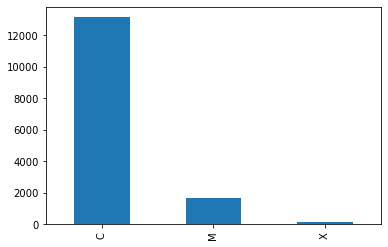

In [131]:
flare_ar_df["goes_class_ind"].value_counts().plot.bar()

In [132]:
## read in flarelist
flare_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/swpc_flarelist_19960731_20181231.csv")
# create a column "matchtime" which will be used to merge with the AR data
flare_list["matchtime"] = pd.to_datetime(flare_list["start_time"], format="%Y-%m-%d %H:%M:%S").dt.strftime("%Y-%m-%d 00:30")



In [136]:
flare_list["noaa_ar"][0]

0

## Testing merged data from `making_ml_df_sc23-24.py`

In [139]:
flare_ana = pd.read_csv("flare_AR_23_24.csv")
flare_ana = flare_ana[~flare_ana["ar_noaanum"].isnull()]
flare_ana.reset_index(inplace=True, drop=True)

In [143]:
len(flare_ana["LOCATION"].iloc[0])

6

In [147]:
location = flare_ana["LOCATION"].iloc[0]

In [148]:
location

'S12E64'

In [149]:
location[0:3]

'S12'

In [150]:
location[3:]

'E64'

In [151]:
lat = location[0:3]
long = location[3:]

In [160]:
def get_lat_long(location):
    location_dict = {"S":-1, "N":1, "E":-1, "W":1}
    lat = location[0:3]
    long = location[3:]

    lat = location_dict[lat[0]]*int(lat[1:])
    long = location_dict[long[0]]*int(long[1:])
    
    return lat, long

In [161]:
get_lat_long(flare_ana["LOCATION"].iloc[100])

(-19, 12)

In [162]:
flare_ana["LOCATION"].iloc[100]

'S19W12'

In [163]:
lat, long = [], []
for i in range(len(flare_ana)):
    latt, longg = get_lat_long(flare_ana["LOCATION"].iloc[i])
    lat.append(latt)
    long.append(longg)

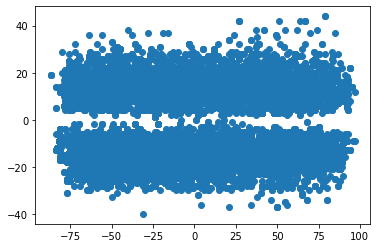

In [167]:
plt.scatter(long, lat)

(array([ 790., 1696., 1877., 1860., 1807., 1739., 1661., 1751., 1244.,
         542.]),
 array([-87. , -68.6, -50.2, -31.8, -13.4,   5. ,  23.4,  41.8,  60.2,
         78.6,  97. ]),
 <BarContainer object of 10 artists>)

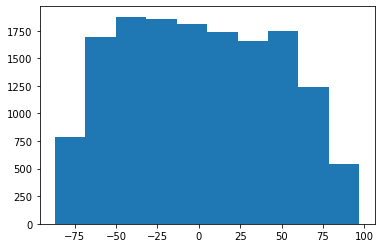

In [168]:
plt.hist(long)

(array([  23.,  518., 3763., 3382.,  440., 1938., 3268., 1465.,  142.,
          28.]),
 array([-40. , -31.6, -23.2, -14.8,  -6.4,   2. ,  10.4,  18.8,  27.2,
         35.6,  44. ]),
 <BarContainer object of 10 artists>)

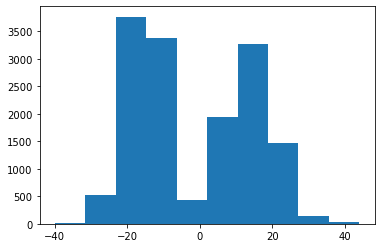

In [169]:
plt.hist(lat)

In [186]:
flare_ana

,matchtime,goes_class_ind,noaa_ar,C,M,X,C+,M+,X+,ar_noaanum,LOCATION,Carrington_long,AREA,Z,Longitude_extent,No_sunspots,MAGTYPE,AR issue_date
0,1996-08-25 00:30,C,7986,1,0,0,1,0,0,7986.0,S12E64,258.0,90.0,HSX,2.0,1.0,ALPHA,1996-08-25 00:30
1,1996-11-24 00:30,C,7999,1,0,0,1,0,0,7999.0,S04E33,169.0,170.0,DAO,8.0,21.0,BETA,1996-11-24 00:30
2,1996-11-24 00:30,C,7999,1,0,0,1,0,0,7999.0,S04E33,169.0,170.0,DAO,8.0,21.0,BETA,1996-11-24 00:30
3,1996-11-24 00:30,C,7999,1,0,0,1,0,0,7999.0,S04E33,169.0,170.0,DAO,8.0,21.0,BETA,1996-11-24 00:30
4,1996-11-24 00:30,C,7999,1,0,0,1,0,0,7999.0,S04E33,169.0,170.0,DAO,8.0,21.0,BETA,1996-11-24 00:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14962,2018-02-10 00:30,C,12699,1,0,0,1,0,0,12699.0,S07E13,166.0,210.0,DAI,9.0,13.0,BETA,2018-02-10 00:30
14963,2018-02-12 00:30,C,12699,1,0,0,1,0,0,12699.0,S07W14,167.0,230.0,DAI,10.0,14.0,BETA,2018-02-12 00:30
14964,2018-03-02 00:30,C,12700,1,0,0,1,0,0,12700.0,N08W55,330.0,10.0,AXX,1.0,1.0,ALPHA,2018-03-02 00:35
14965,2018-05-28 00:30,C,12712,1,0,0,1,0,0,12712.0,N15E28,179.0,40.0,CRO,9.0,5.0,BETA,2018-05-28 00:30
